In [85]:
import numpy as np
import pandas as pd
import string
import contractions
from collections import Counter


import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = stopwords.words('english')
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

In [86]:
#read csv file
df = pd.read_csv('product_reviews.csv')
df.head()

,Review
0,Ive been walking over ten years and have been ...
1,"Read the instructions, setup with average fema..."
2,"INACCURATE! Both of these are the same brand, ..."
3,"I’ve never used it, it’s too complicated to se..."
4,The first one I purchased failed after four da...


In [87]:
#remove stop words
def remove_stopwords(df):
    nsw_df = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    df['Review'] = nsw_df
    return df


In [88]:
# create function for punctuation removal:
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text

In [89]:


# remove '\n' and punctuation, lowercase all letters
df['Review'] = df['Review'].str.replace('\n',' ').str.lower()

# expand contractions
df['Review'] = df['Review'].apply(lambda x: contractions.fix(x))

# remove punctuations
df['Review'] = df['Review'].apply(remove_punctuations)

# remove stopwords
df= remove_stopwords(df)

df.head()

,Review
0,walking ten years used variety pedometers time...
1,read instructions setup average female stride ...
2,inaccurate brand start top one new one bottom ...
3,never used complicated set worthless even says...
4,first one purchased failed four days use steps...


In [ ]:
# function for checking popular words:
def popular_words(col):
    splitted = col.apply(lambda x:str(x).split())

    top = Counter([item for sublist in col for item in sublist])

    return pd.DataFrame(top.most_common(10))

popular_words(df['Review'])

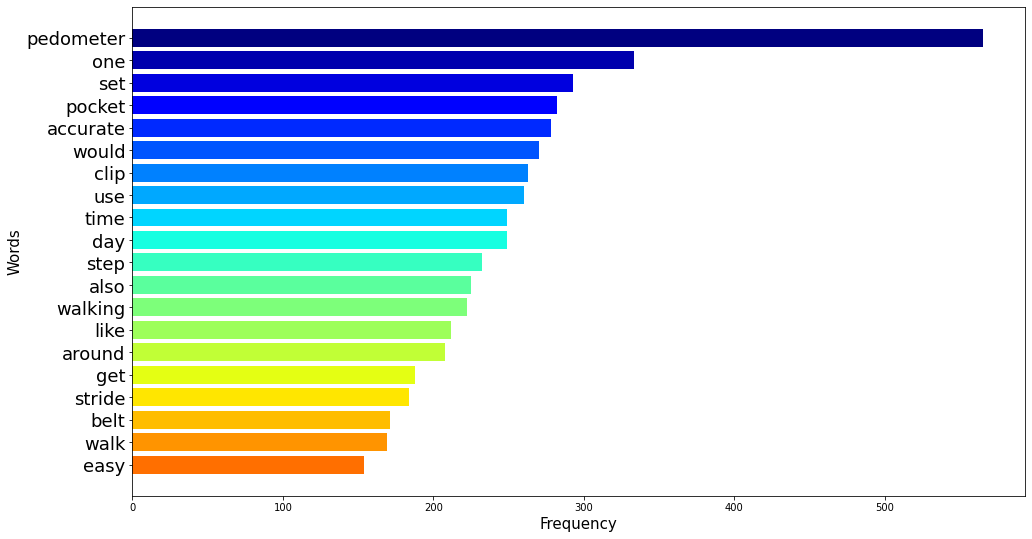

In [106]:

# popular words
words = [x.split() for x in df.Review.values]
from itertools import chain
cx = Counter(list(chain(*words)))
top = 20
most_common = cx.most_common()[1:]
x, y = zip(*most_common[:top])
fig, ax = plt.subplots(1, figsize=(16,9))
ax.barh(range(len(x)), y, color = plt.cm.jet(np.linspace(0, 1, 25)))
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Words' , fontsize=15)
ax.set_yticks(np.arange(len(x)))
ax.set_yticklabels(x, fontsize=18)
plt.show()

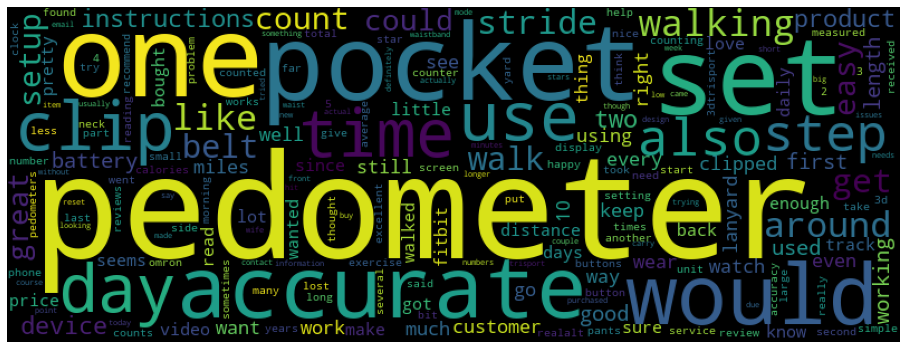

In [92]:
# visualization
d = {}
for k,v in most_common[:]:
    d[k] = int(v)

wc = WordCloud(relative_scaling=.5, width=800, height=300, background_color='black').generate_from_frequencies(d)
fig = plt.figure(1,figsize=(16,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [93]:
# trio combination words
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder_ = TrigramCollocationFinder.from_words(list(chain(*words)),3)


for trigram in finder_.nbest(trigram_measures.likelihood_ratio, 20):
    print(trigram)
    
bgs3 = nltk.trigrams(list(chain(*words))) 
fdist3 = nltk.FreqDist(bgs3)
rslt3 = pd.DataFrame(Counter(fdist3).most_common(20),columns=['Word', 'Frequency']).set_index('Word')
print('=' * 60)
print(rslt3)
print('=' * 60)

('average', 'stride', 'length')
('stride', 'length', 'stride')
('adjust', 'stride', 'length')
('length', 'stride', 'length')
('change', 'stride', 'length')
('realalt', 'customer', 'service')
('measure', 'stride', 'length')
('customer', 'service', 'discussed')
('customer', 'service', 'workrecommended')
('realalt’s', 'customer', 'service')
('female', 'stride', 'length')
('stride', 'length', 'help')
('stride', 'length', 'wanting')
('customer', 'service', 'generosity')
('customer', 'service', 'hoping')
('customer', 'service', 'responsive')
('trisports', 'customer', 'service')
('meant', 'stride', 'length')
('stride', 'length', 'accordingly')
('stride', 'length', 'momentum')
                                Frequency
Word                                     
(average, stride, length)              20
(two, star, product)                   18
(walking, 3d, pedometer)               17
(wear, around, neck)                   16
(would, definitely, recommend)         15
(r, measured, higher)       

In [101]:
# aplly sentiment score
from textblob import TextBlob
df["sentiment_score"] = df["Review"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df["sentiment"] = np.select([df["sentiment_score"] < 0, df["sentiment_score"] == 0, df["sentiment_score"] > 0],
                           ['neg', 'neu', 'pos'])


In [107]:
# find only negative reviews
df_neg = df[df['sentiment'] == 'neg']
df_neg

,Review,sentiment_score,sentiment
0,walking ten years used variety pedometers time...,-0.003632,neg
1,read instructions setup average female stride ...,-0.018678,neg
3,never used complicated set worthless even says...,-0.231250,neg
6,walked 2 20 minute miles marked walking 16 bou...,-0.033333,neg
9,received realalt 3dtrisport walking 3d pedomet...,-0.075926,neg
...,...,...,...
418,walking ten years used variety pedometers time...,-0.003632,neg
423,ordered product felt beneficial milage calorie...,-0.022727,neg
425,difficult set due extremely small graphicscloc...,-0.232143,neg
434,use 3dtrisport walking 3d pedometer count dail...,-0.033333,neg


In [109]:
# download to csv
df_neg.to_csv('cleaned_bad_reviews.csv', index=False, encoding='utf-8')